In [127]:
import numpy as np
import pymc as pm
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import itertools

from matplotlib.lines import Line2D
from scipy.stats import multivariate_normal
import matplotlib.cm as cm

# Missing data imputation

In [12]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/My Drive/Cyclingdata.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Accident_Index,Number_of_Vehicles,Number_of_Casualties,Date,Time,Speed_limit,Road_conditions,Weather_conditions,Day,Road_type,Light_conditions,Gender,Severity,Age_Grp
0,19893389M0115,2,1,1989-05-13,12:50:00,40,Dry,Clear,Saturday,Single carriageway,Daylight,Male,Slight,16 to 20
1,201201CW10530,2,1,2012-03-05,12:10:00,30,Dry,Clear,Thursday,Single carriageway,Daylight,Male,Slight,21 to 25
2,19894200C0467,2,1,1989-04-14,16:55:00,30,Dry,Clear,Friday,Single carriageway,Daylight,Male,Slight,6 to 10
3,2014450012509,2,2,2014-01-14,08:19:00,40,Frost,Unknown,Tuesday,Single carriageway,Daylight,Male,Slight,36 to 45
4,198801DD00558,2,1,1988-11-23,10:20:00,30,Dry,Clear,Wednesday,Dual carriageway,Daylight,Male,Slight,26 to 35


In [3]:
# Improved version of time getter
def TimeGetter(time):
    """
    Determines the part of the day (Morning, Midday, Afternoon, Evening, Night) based on the given time.

    Parameters:
    - time (str): The time in "HH:MM:SS" format.

    Returns:
    - str: The part of the day as a string ("Morning", "Midday", "Afternoon", "Evening", or "Night").
    """
    hours, minutes, seconds = [int(part) for part in time.split(':')]
    total_seconds = hours * 3600 + minutes * 60 + seconds
    if 6*3600 <= total_seconds < 9*3600:
        return "Morning"
    elif 9*3600 <= total_seconds < 14*3600:
        return "Midday"
    elif 14*3600 <= total_seconds < 18*3600:
        return "Afternoon"
    elif 18*3600 <= total_seconds < 22*3600:
        return "Evening"
    else:
        return "Night"

In [14]:
# Improved version of data wrangling code
weekday_mapping = {'Monday': 1, 'Tuesday': 1, 'Wednesday': 1, 'Thursday': 1, 'Friday': 1, 'Saturday': 0, 'Sunday': 0}
df['Day'] = df['Day'].map(weekday_mapping)
df["TimeDay"] = df["Time"].apply(TimeGetter)
df["DryRoad"] = (df["Road_conditions"] == "Dry").astype(int)
df["Clear"] = (df["Weather_conditions"] == "Clear").astype(int)
df["Dark"] = (df["Light_conditions"] == "Darkness no lights").astype(int)
df["DualCarriageway"] = (df["Road_type"] == "Dual carriageway").astype(int)
df["over55"] = df["Age_Grp"].isin(["56 to 65", "66 to 75"]).astype(int)
df["Severity_binary"] = (df["Severity"] != "Slight").astype(int)
print(df['Light_conditions'].unique())
for part_of_day in ["Night", "Morning", "Midday", "Afternoon", "Evening"]:
    df[part_of_day] = (df["TimeDay"] == part_of_day).astype(int)
features = ["Severity_binary", "Day", "Speed_limit", "DryRoad", "Clear", "DualCarriageway", "over55", "TimeDay", "Night", "Morning", "Midday", "Afternoon", "Evening", "Dark"]
df2 = df[features]
df2.head(10)

['Daylight' 'Darkness lights lit' 'Darkness no lights']


,Severity_binary,Day,Speed_limit,DryRoad,Clear,DualCarriageway,over55,TimeDay,Night,Morning,Midday,Afternoon,Evening,Dark
0,0,0,40,1,1,0,0,Midday,0,0,1,0,0,0
1,0,1,30,1,1,0,0,Midday,0,0,1,0,0,0
2,0,1,30,1,1,0,0,Afternoon,0,0,0,1,0,0
3,0,1,40,0,0,0,0,Morning,0,1,0,0,0,0
4,0,1,30,1,1,1,0,Midday,0,0,1,0,0,0
5,0,1,30,0,0,0,0,Evening,0,0,0,0,1,0
6,0,1,30,1,0,0,0,Afternoon,0,0,0,1,0,0
7,1,0,30,1,1,0,1,Midday,0,0,1,0,0,0
8,0,1,30,1,1,0,0,Afternoon,0,0,0,1,0,0
9,0,1,40,1,1,0,0,Morning,0,1,0,0,0,0


In [16]:
df2.shape

(200000, 14)

In [15]:
df2.isna().sum() #/ len(df)

Severity_binary    0
Day                0
Speed_limit        0
DryRoad            0
Clear              0
DualCarriageway    0
over55             0
TimeDay            0
Night              0
Morning            0
Midday             0
Afternoon          0
Evening            0
Dark               0
dtype: int64

The data set does not contain any missing observations, so I will randomly add missing values to the data set to mimic the scenario and meet the MCAR assumption at the same time. I will also only work with the first 1000 observations.

In [59]:
df3 = df2[:200]
missingness_percentage = 0.1
np.random.seed(seed=1007501482)
missing_mask = np.random.rand(*df3.shape) < missingness_percentage
for column in df3.columns:
    df3.loc[missing_mask[:, df3.columns.get_loc(column)], column] = np.nan
df3.isna().sum() / len(df3)

Severity_binary    0.145
Day                0.125
Speed_limit        0.075
DryRoad            0.110
Clear              0.105
DualCarriageway    0.100
over55             0.070
TimeDay            0.715
Night              0.110
Morning            0.105
Midday             0.090
Afternoon          0.120
Evening            0.075
Dark               0.130
dtype: float64

In [60]:
# df4 = df3[['Speed_limit', 'DryRoad', 'Clear',  'DualCarriageway', 'Dark']]
df4 = df3[['Speed_limit', 'DryRoad', 'Clear',  'DualCarriageway', 'Night', 'Morning',
           'Midday',  'Afternoon', 'Evening', 'Dark']]
df4.shape

(200, 10)

I've made a simpler version of the decomposition of the joint distribution. Usually, suppose we have 4 variables $x_1,x_2,x_3, x_4$, then we have the joint distribution
$$p(x_1,x_2,x_3,x_4)=p(x_1)\times p(x_2|x_1)\times p(x_3|x_1,x_2)\times p(x_4|x_1,x_2,x_3)$$
but if all variables are independent, then
$$p(x_1,x_2,x_3,x_4)=p(x_1)\times p(x_2|x_1)\times p(x_3|x_1)\times p(x_4|x_1)$$
My code below draws from the above decomposition of the mixture model with the independence assumption. I will estimate the posterior of `Speed_limit` and then estimate the posterior of the other 9 binary variables as a Bernoulli distribution where $p$ is regressed on `Speed_limit`. If I am to drop the independence assumption, then we would need to estimate 45 $\beta$s and 10 $\alpha$s, which is beyond our computational capacity.

/usr/local/lib/python3.10/dist-packages/pymc/model/core.py:1316: ImputationWarning: Data in speed_limit_pred contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


/usr/local/lib/python3.10/dist-packages/pymc/model/core.py:1316: ImputationWarning: Data in speed_limit_pred contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


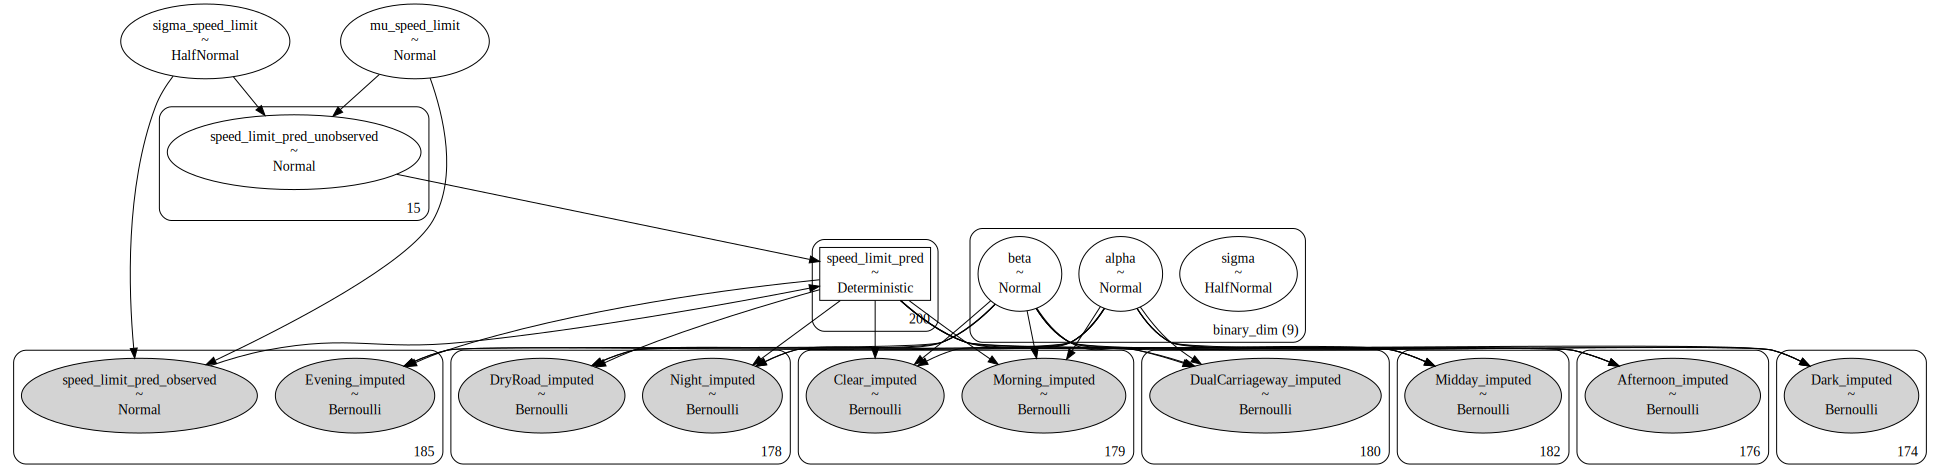

In [82]:
speed_limit_mean = df4["Speed_limit"].mean()
speed_limit_sd = df4["Speed_limit"].std()
speed_limit_min = df4["Speed_limit"].min()
speed_limit_max = df4["Speed_limit"].max()
priors = {"Speed_limit": {"normal": [speed_limit_mean, speed_limit_sd, speed_limit_sd],
                          "uniform": [speed_limit_min, speed_limit_max]},}


def make_model(priors, normal_pred_assumption=True):
    coords = {"binary_dim": ["DryRoad", "Clear", "DualCarriageway", "Night",
                             "Morning", "Midday", "Afternoon", "Evening", "Dark"],}
    with pm.Model(coords=coords) as model:
      beta = pm.Normal("beta", 0, 1, dims="binary_dim")
      alpha = pm.Normal("alpha", 10, 5, dims="binary_dim")
      sigma = pm.HalfNormal("sigma", 5, dims="binary_dim")

      if normal_pred_assumption:
        mu_speed_limit = pm.Normal("mu_speed_limit", priors["Speed_limit"]["normal"][0],
                                   priors["Speed_limit"]["normal"][1])
        sigma_speed_limit = pm.HalfNormal("sigma_speed_limit",
                                          priors["Speed_limit"]["normal"][2])
        speed_limit_pred = pm.Normal("speed_limit_pred", mu_speed_limit,
                                     sigma_speed_limit, observed=df4["Speed_limit"])
      else:
        speed_limit_pred = pm.Uniform("speed_limit_pred", speed_limit_min,
                                      speed_limit_max, observed=df4["Speed_limit"])

      for i, var in enumerate(coords["binary_dim"]):
        observed = df4[var].dropna()
        mu_binary = alpha[coords["binary_dim"].index(var)] + beta[coords["binary_dim"].index(var)] * speed_limit_pred
        pm.Bernoulli(f"{var}_imputed", pm.math.sigmoid(mu_binary[i]), observed=observed)

      idata = pm.sample_prior_predictive()
      idata.extend(pm.sample(random_seed=1007501482, return_inferencedata=True))
      pm.sample_posterior_predictive(idata, extend_inferencedata=True)

    return idata, model


idata_uniform, model_uniform = make_model(priors, normal_pred_assumption=False)
idata_normal, model_normal = make_model(priors, normal_pred_assumption=True)
pm.model_to_graphviz(model_normal)

Next we will do model diagnostics on the imputation model.

In [70]:
az.summary(idata_normal).head(20)

/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (be

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[DryRoad],-0.223,0.123,-0.465,-0.002,0.003,0.002,2232.0,1204.0,1.0
beta[Clear],-0.264,0.163,-0.553,0.051,0.004,0.003,1968.0,1352.0,1.0
beta[DualCarriageway],-0.399,0.166,-0.700,-0.074,0.003,0.002,2535.0,1311.0,1.0
beta[Night],-0.318,0.125,-0.567,-0.098,0.003,0.002,2325.0,1552.0,1.0
beta[Morning],-0.382,0.165,-0.690,-0.076,0.003,0.002,2651.0,1328.0,1.0
beta[Midday],-0.370,0.215,-0.785,-0.032,0.006,0.005,1711.0,1067.0,1.0
beta[Afternoon],-0.345,0.164,-0.655,-0.054,0.003,0.003,2241.0,1597.0,1.0
beta[Evening],-0.375,0.163,-0.659,-0.037,0.003,0.003,2763.0,1182.0,1.0
beta[Dark],-0.458,0.164,-0.737,-0.117,0.004,0.003,2146.0,1276.0,1.0
alpha[DryRoad],9.911,4.906,0.969,19.432,0.103,0.077,2245.0,1252.0,1.0


In [71]:
az.summary(idata_uniform).head(20)

/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (be

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[DryRoad],-0.224,0.122,-0.471,-0.009,0.003,0.002,1999.0,1438.0,1.0
beta[Clear],-0.265,0.162,-0.576,0.027,0.004,0.003,1722.0,1499.0,1.0
beta[DualCarriageway],-0.389,0.165,-0.713,-0.105,0.004,0.003,1993.0,1528.0,1.0
beta[Night],-0.318,0.121,-0.559,-0.104,0.003,0.002,2012.0,1298.0,1.0
beta[Morning],-0.384,0.171,-0.693,-0.051,0.004,0.003,2045.0,1242.0,1.0
beta[Midday],-0.303,0.183,-0.675,-0.010,0.005,0.004,1887.0,966.0,1.0
beta[Afternoon],-0.337,0.159,-0.654,-0.050,0.003,0.002,2478.0,1326.0,1.0
beta[Evening],-0.373,0.162,-0.657,-0.051,0.004,0.003,2039.0,1455.0,1.0
beta[Dark],-0.460,0.168,-0.782,-0.163,0.004,0.003,2267.0,1476.0,1.0
alpha[DryRoad],9.962,4.899,1.531,19.928,0.110,0.081,1996.0,1437.0,1.0


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'mu_speed_limit'}>,
        <Axes: title={'center': 'mu_speed_limit'}>],
       [<Axes: title={'center': 'speed_limit_pred_unobserved'}>,
        <Axes: title={'center': 'speed_limit_pred_unobserved'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'sigma_speed_limit'}>,
        <Axes: title={'center': 'sigma_speed_limit'}>],
       [<Axes: title={'center': 'speed_limit_pred'}>,
        <Axes: title={'center': 'speed_limit_pred'}>]], dtype=object)

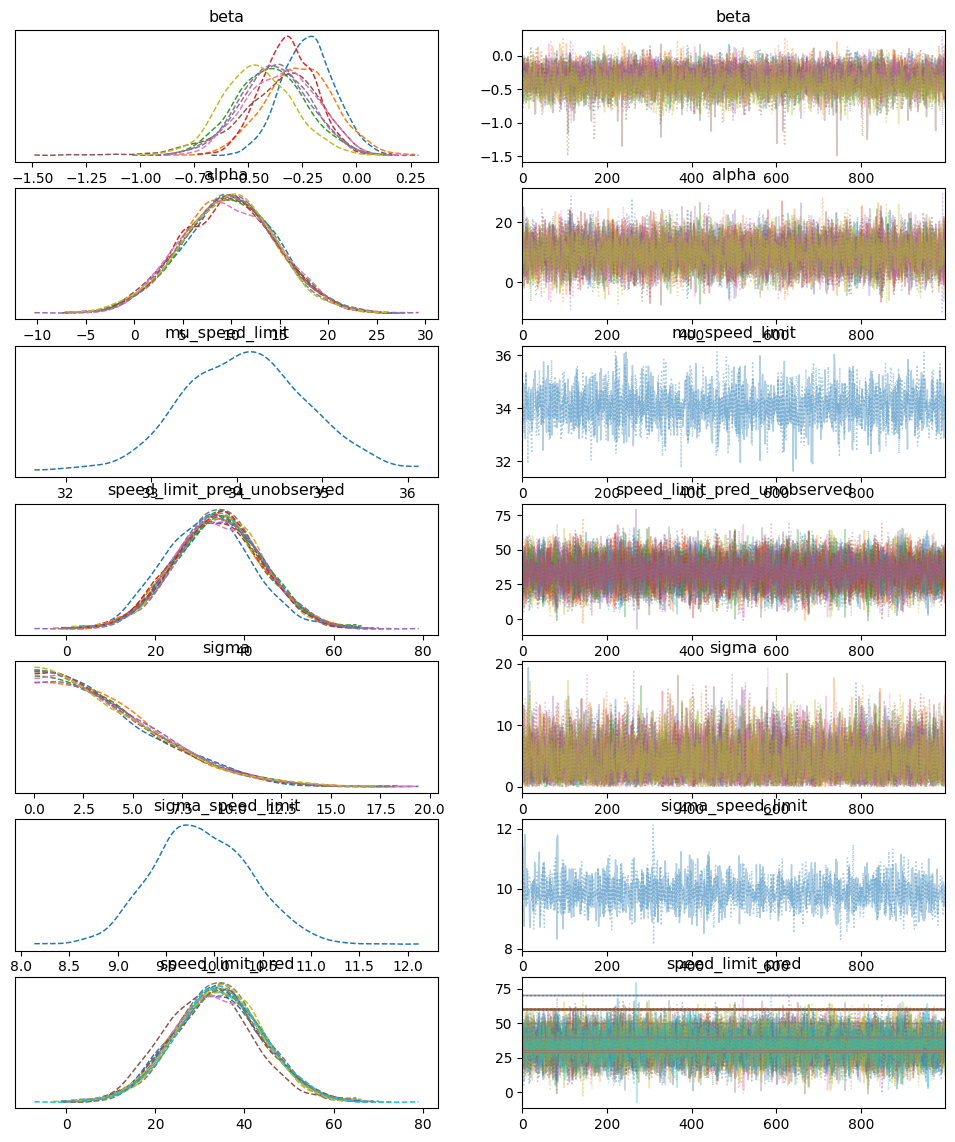

In [72]:
az.plot_trace(idata_normal, combined=True)

/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'speed_limit_pred_unobserved'}>,
        <Axes: title={'center': 'speed_limit_pred_unobserved'}>],
       [<Axes: title={'center': 'speed_limit_pred'}>,
        <Axes: title={'center': 'speed_limit_pred'}>]], dtype=object)

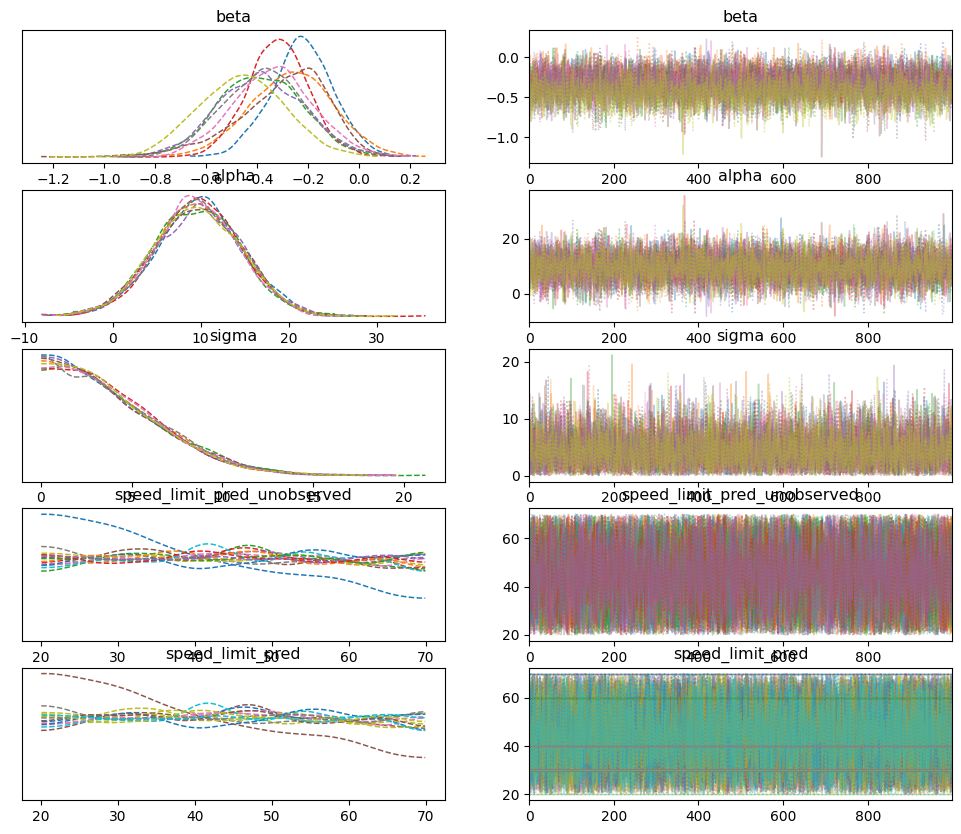

In [73]:
az.plot_trace(idata_uniform, combined=True)

array([<Axes: >], dtype=object)

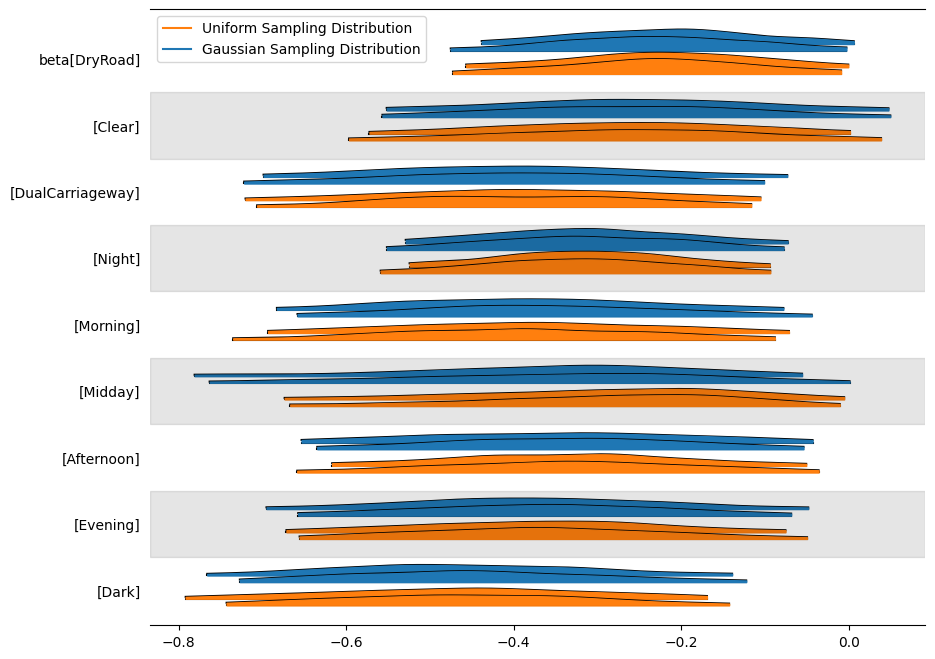

In [74]:
az.plot_forest(
    [idata_normal, idata_uniform],
    var_names=["beta"],
    kind="ridgeplot",
    model_names=["Gaussian Sampling Distribution", "Uniform Sampling Distribution"],
    figsize=(10, 8),
)

We will obtain the imputed values and plot them.

In [109]:
def get_imputed(idata, data):
    imputed_data = data.copy()

    imputed_speed_limit = az.extract(idata, group="posterior_predictive",
                                     num_samples=200)["speed_limit_pred"].mean(axis=1)
    mask = imputed_data["Speed_limit"].isnull()
    imputed_data.loc[mask, "Speed_limit"] = imputed_speed_limit.values[imputed_data[mask].index]

    for var in ["DryRoad", "Clear", "DualCarriageway", "Night", "Morning",
                "Midday", "Afternoon", "Evening", "Dark"]:
        imputed_var = az.extract(idata, group="posterior_predictive", num_samples=200)[f"{var}_imputed"].mean(axis=1)
        imputed_var = np.round(imputed_var, 0)
        mask = imputed_data[var].isnull()
        #imputed_data.loc[mask, var] = imputed_var.values[imputed_data[mask].index]
        imputed_data.loc[mask, var] = imputed_var[:mask.sum()]

    assert imputed_data.isnull().sum().sum() == 0, "Some variables still contain missing values after imputation."
    imputed_data.columns = ["imputed_" + col for col in imputed_data.columns]

    return imputed_data


imputed_data_normal = get_imputed(idata_normal, df4)
imputed_data_uniform = get_imputed(idata_uniform, df4)
imputed_data_normal.head(5)

,imputed_Speed_limit,imputed_DryRoad,imputed_Clear,imputed_DualCarriageway,imputed_Night,imputed_Morning,imputed_Midday,imputed_Afternoon,imputed_Evening,imputed_Dark
0,40.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,30.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,30.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,30.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


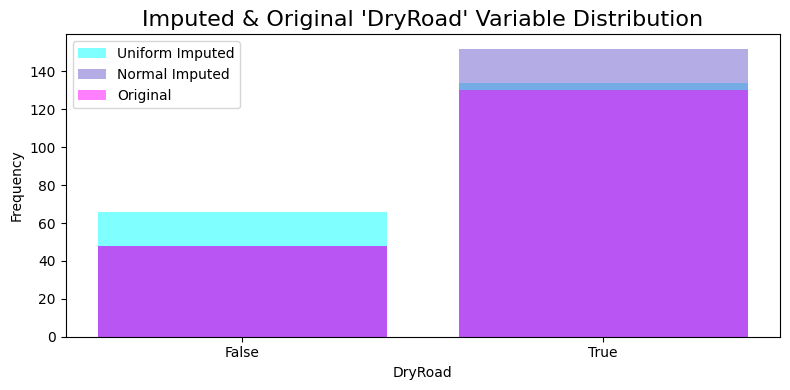

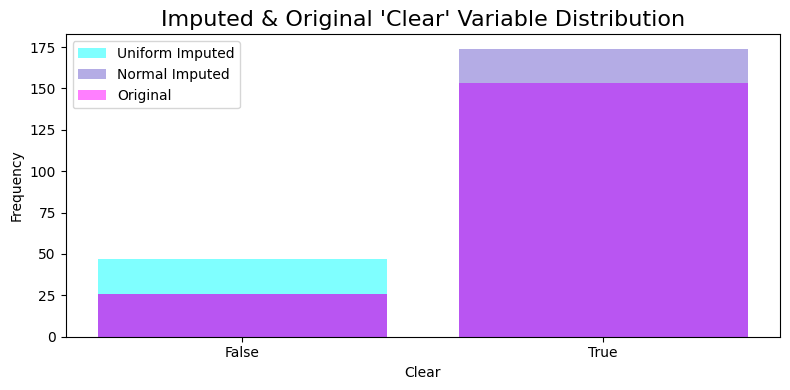

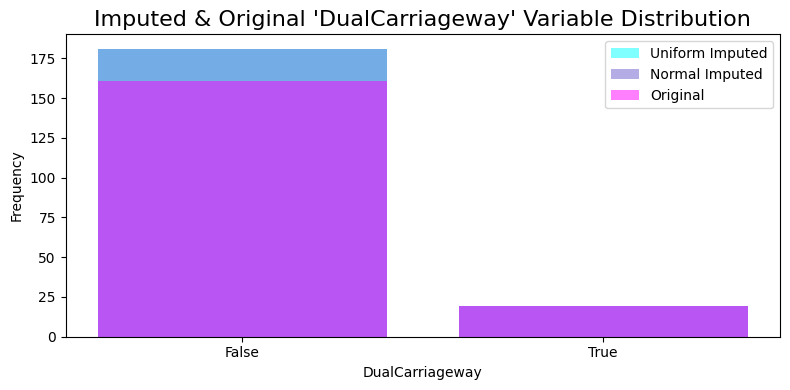

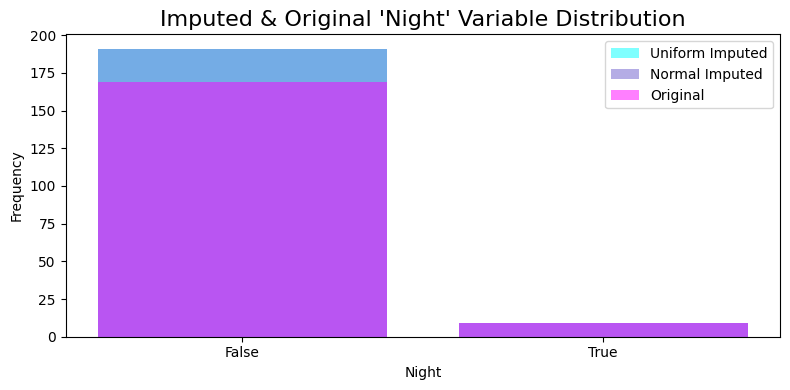

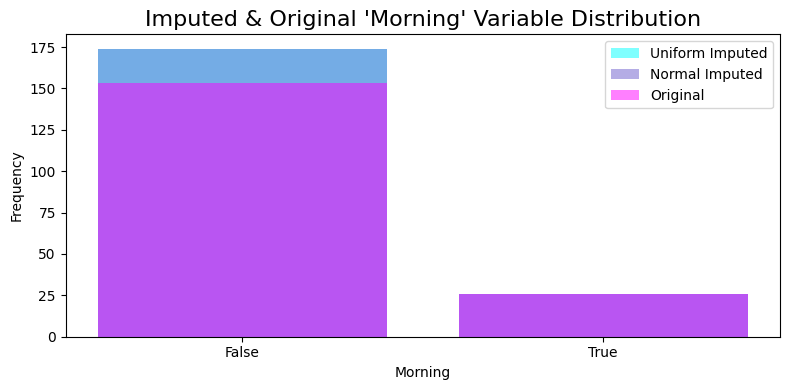

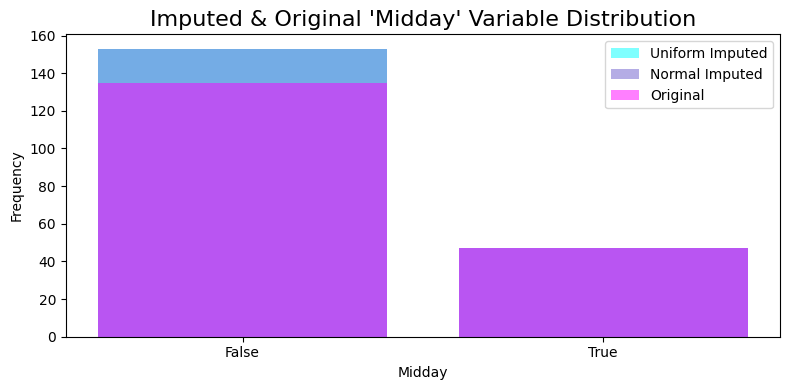

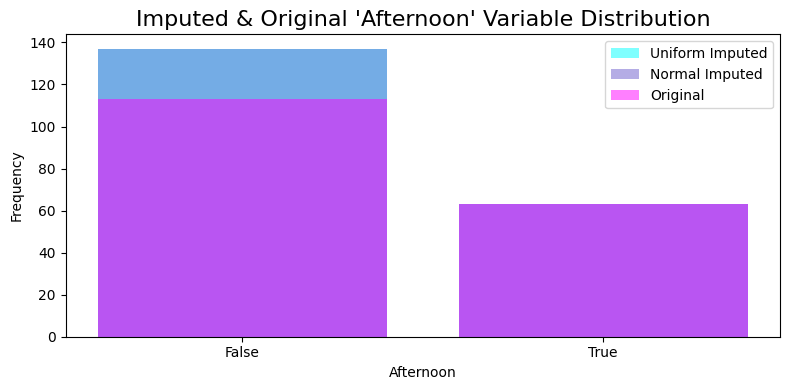

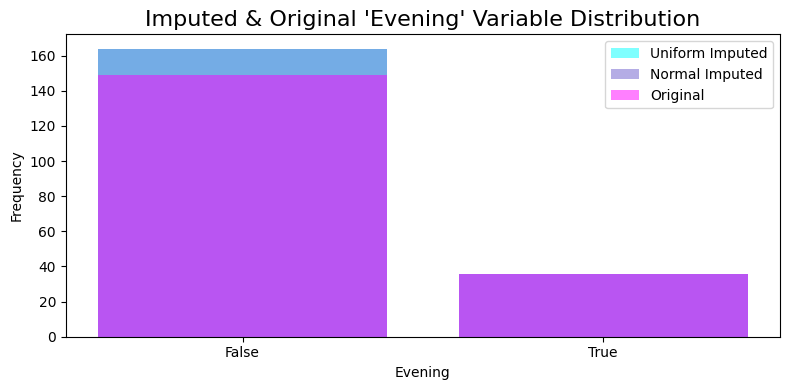

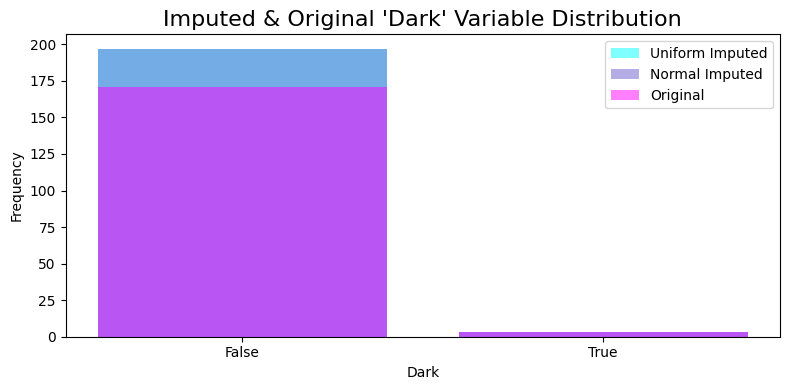

In [110]:
def plot_binary_variable_distribution(data_original, data_uniform, data_normal, variable_name):
    fig, ax = plt.subplots(figsize=(8, 4))
    bins = [-0.5, 0.5, 1.5]
    labels = ["False", "True"]
    alpha = 0.5
    rwidth = 0.8
    ax.hist(data_uniform["imputed_"+variable_name], bins=bins, alpha=alpha, label="Uniform Imputed", color="cyan", rwidth=rwidth)
    ax.hist(data_normal["imputed_"+variable_name], bins=bins, alpha=alpha, label="Normal Imputed", color="slateblue", rwidth=rwidth)
    ax.hist(data_original[variable_name], bins=bins, alpha=alpha, label="Original", color="magenta", rwidth=rwidth)
    ax.legend()
    ax.set_title(f"Imputed & Original '{variable_name}' Variable Distribution", fontsize=16)
    ax.set_xlabel(variable_name)
    ax.set_ylabel("Frequency")
    ax.set_xticks([0, 1])
    ax.set_xticklabels(labels)

    plt.tight_layout()
    plt.show()


binary_variables = ["DryRoad", "Clear", "DualCarriageway", "Night", "Morning",
                    "Midday", "Afternoon", "Evening", "Dark"]

for variable in binary_variables:
    plot_binary_variable_distribution(df4, imputed_data_uniform, imputed_data_normal, variable)

In [116]:
def retrieve_original_values(original_df, modified_df, column_name):
    """
    Function to retrieve the original values of a column before missingness was introduced.

    Parameters:
    - original_df: The original DataFrame before missing values were introduced.
    - modified_df: The modified DataFrame with missing values.
    - column_name: The name of the column for which to retrieve original values.

    Returns:
    A pandas Series containing the original values of the specified column.
    """
    if column_name in original_df.columns and column_name in modified_df.columns:
        original_values = original_df[column_name].where(modified_df[column_name].isna(), modified_df[column_name])
        return original_values
    else:
        raise ValueError("Column name not found in one of the DataFrames.")


df5 = df2[['Speed_limit', 'DryRoad', 'Clear',  'DualCarriageway', 'Night', 'Morning',
           'Midday',  'Afternoon', 'Evening', 'Dark']]
df5 = df5[:200]

In [124]:
def compare_distributions(imputed_data_uniform, imputed_data_normal, variable_name):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.hist(retrieve_original_values(df5, df4, variable_name), bins=30, alpha=0.5, label="Original", color="purple")
    ax.hist(imputed_data_uniform["imputed_"+variable_name], bins=30, alpha=0.5, label="Uniform Imputed", color="cyan")
    ax.hist(imputed_data_normal["imputed_"+variable_name], bins=30, alpha=0.5, label="Normal Imputed", color="magenta")
    ax.legend()
    ax.set_title(f"Distribution of {variable_name}: Original vs Imputed")
    ax.set_xlabel(variable_name)
    ax.set_ylabel("Frequency")
    plt.show()

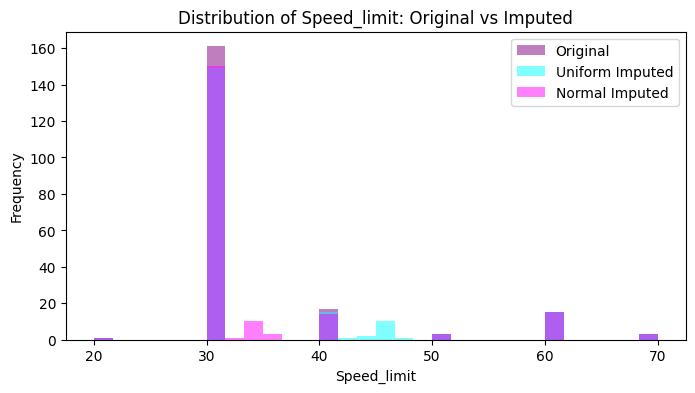

In [126]:
compare_distributions(imputed_data_uniform= imputed_data_uniform,
                      imputed_data_normal=imputed_data_normal,
                      variable_name="Speed_limit")

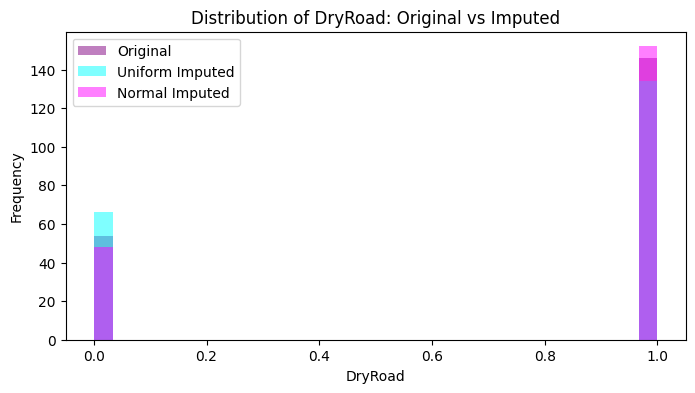

In [125]:
compare_distributions(imputed_data_uniform, imputed_data_normal, "DryRoad")